In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import product
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
import lightgbm as lgb
import calendar
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# import all csvs
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
sales = pd.read_csv('competitive-data-science-predict-future-sales/sales_train.csv')
shops = pd.read_csv('competitive-data-science-predict-future-sales/shops.csv')
items = pd.read_csv('competitive-data-science-predict-future-sales/items.csv')
item_categories = pd.read_csv('competitive-data-science-predict-future-sales/item_categories.csv')

# Perform Data Exporation

In [3]:
test.head()

,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [5]:
shops.head()

,shop_name,shop_id
0,"!Якутск Орджоникидзе, 56 фран",0
1,"!Якутск ТЦ ""Центральный"" фран",1
2,"Адыгея ТЦ ""Мега""",2
3,"Балашиха ТРК ""Октябрь-Киномир""",3
4,"Волжский ТЦ ""Волга Молл""",4


In [6]:
items.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


In [7]:
item_categories.head()

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


# Inspect Data & Find Anomolies

<AxesSubplot:>

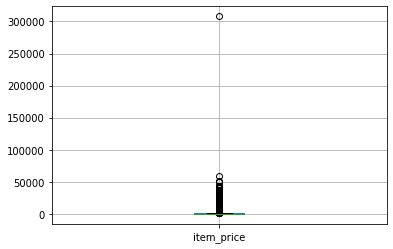

In [8]:
# This box plot shows distinct outliers (e.g., > 10000, < 0)
sales.boxplot(column=['item_price'])

In [9]:
# correct the anomolies
lessthanzero = sales[sales.item_price <= 0]
lessthanzero.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
484683,15.05.2013,4,32,2973,-1.0,1.0


In [10]:
sales_train = sales[(sales.item_price > 0) & (sales.item_price < 300000)]

<AxesSubplot:>

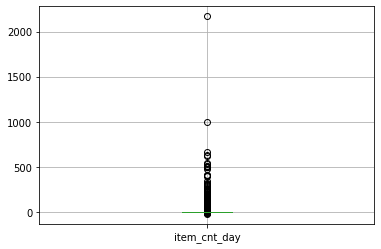

In [11]:
# This box plot shows distinct outliers (e.g., > 750, < 0) - where < 0 may be thought of as returns/refunds
sales_train.boxplot(column=['item_cnt_day'])

In [12]:
sales_train = sales_train[sales_train.item_cnt_day < 750]

<AxesSubplot:>

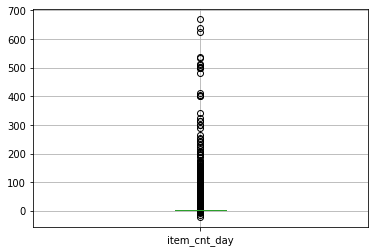

In [13]:
sales_train.boxplot(column=['item_cnt_day'])

# Items Data Prep. & Feature Engineering

In [14]:
pd.options.display.max_rows = 1000
item_categories.head(100)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [15]:
# merge items and item_categories data set on 'item_category_id' to begin crafting
# complete data set
items = pd.merge(items, item_categories, on='item_category_id')
items.head()

,item_name,item_id,item_category_id,item_category_name
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD


In [16]:
# generate a feature called 'genre' to categorize into categories and subcategories
items['genre'] = items['item_category_name'].apply(lambda x: x.split('-')[0])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино


In [17]:
# adjust some anomolies in the dataset and re-perform feature computation
manual_genre_edit = {
            'Чистые носители (штучные)': 'Чистые носители',
            'Чистые носители (шпиль)' : 'Чистые носители', #Blank Media
            'PC ': 'Аксессуары', ## PC -> Accessories
            'Служебные': 'Служебные ' #Service
            }


items['genre'] = items['genre'].apply(lambda x: manual_genre_edit[x] if x in manual_genre_edit.keys() else x)

In [18]:
# OneHotEncoding - take categories and convert them to numerical data
items['genre_id'] = LabelEncoder().fit_transform(items['genre'])
items.head()

,item_name,item_id,item_category_id,item_category_name,genre,genre_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40,Кино - DVD,Кино,11
1,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40,Кино - DVD,Кино,11
2,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40,Кино - DVD,Кино,11
3,***КОРОБКА (СТЕКЛО) D,4,40,Кино - DVD,Кино,11
4,***НОВЫЕ АМЕРИКАНСКИЕ ГРАФФИТИ (UNI) ...,5,40,Кино - DVD,Кино,11


In [19]:
items = items[['item_id', 'item_category_id', 'genre_id']]
items.head()

,item_id,item_category_id,genre_id
0,0,40,11
1,2,40,11
2,3,40,11
3,4,40,11
4,5,40,11


In [20]:
print(shops)

                                          shop_name  shop_id
0                     !Якутск Орджоникидзе, 56 фран        0
1                     !Якутск ТЦ "Центральный" фран        1
2                                  Адыгея ТЦ "Мега"        2
3                    Балашиха ТРК "Октябрь-Киномир"        3
4                          Волжский ТЦ "Волга Молл"        4
5                            Вологда ТРЦ "Мармелад"        5
6                        Воронеж (Плехановская, 13)        6
7                            Воронеж ТРЦ "Максимир"        7
8                      Воронеж ТРЦ Сити-Парк "Град"        8
9                                 Выездная Торговля        9
10                       Жуковский ул. Чкалова 39м?       10
11                       Жуковский ул. Чкалова 39м²       11
12                              Интернет-магазин ЧС       12
13                              Казань ТЦ "Бехетле"       13
14                          Казань ТЦ "ПаркХаус" II       14
15                      

In [21]:
# correct duplicate shops - access a group of rows and columns by labels
sales_train.loc[sales_train.shop_id == 57, 'shop_id'] = 0
sales_train.loc[sales_train.shop_id == 58, 'shop_id'] = 1
sales_train.loc[sales_train.shop_id == 11, 'shop_id'] = 10
sales_train.loc[sales_train.shop_id == 39, 'shop_id'] = 40

test.loc[test.shop_id == 57, 'shop_id'] = 0
test.loc[test.shop_id == 58, 'shop_id'] = 1
test.loc[test.shop_id == 11, 'shop_id'] = 10
test.loc[test.shop_id == 39, 'shop_id'] = 40

# check the amount of unique shops and compare number of unique entires in sales_train dataset
rows = len(sales_train)
unique_test_shop_id = test['shop_id'].unique()
sales_train = sales_train[sales_train['shop_id'].isin(unique_test_shop_id)]
print(rows - len(sales_train))

502311


In [22]:
# begin adding sales train info
# we want to aggregate all the sales count by month instead of days so that we can view trends in the dataset

# ('date_block_num','shop_id','item_id') provides a unique primary key to access each tuple in the data set.
aggregate_count = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
aggregate_count.columns = ['item_cnt_month']
aggregate_count.reset_index(inplace=True)

aggregate_count.head(1000500)

,date_block_num,shop_id,item_id,item_cnt_month
0,0,0,32,6.0
1,0,0,33,3.0
2,0,0,35,1.0
3,0,0,43,1.0
4,0,0,51,2.0
...,...,...,...,...
1000495,23,46,17818,1.0
1000496,23,46,17865,3.0
1000497,23,46,17866,1.0
1000498,23,46,17867,1.0


In [23]:
#aggregate_days_sold = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['count']})
#aggregate_days_sold.columns = ['days_sold']
#aggregate_days_sold.reset_index(inplace=True)
#aggregate_days_sold.head() 

#cc = aggregate_days_sold.loc[aggregate_days_sold['days_sold'] > 31]
#cc.head()

In [24]:
# now that we have the total monthly sales, we want to determine average price per month

aggregate_price = sales_train.groupby(['date_block_num','shop_id','item_id']).agg({'item_price': ['mean']})
aggregate_price.columns = ['mean_price']
aggregate_price.reset_index(inplace=True)

aggregate_price.head()

,date_block_num,shop_id,item_id,mean_price
0,0,0,32,221.0
1,0,0,33,347.0
2,0,0,35,247.0
3,0,0,43,221.0
4,0,0,51,128.5


In [25]:
# we will now perform left join on the data set so that we can combine the two metrics we computed above
merged = aggregate_count.merge(aggregate_price, on=['date_block_num','shop_id','item_id'], how='left')
merged.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price
0,0,0,32,6.0,221.0
1,0,0,33,3.0,347.0
2,0,0,35,1.0,247.0
3,0,0,43,1.0,221.0
4,0,0,51,2.0,128.5


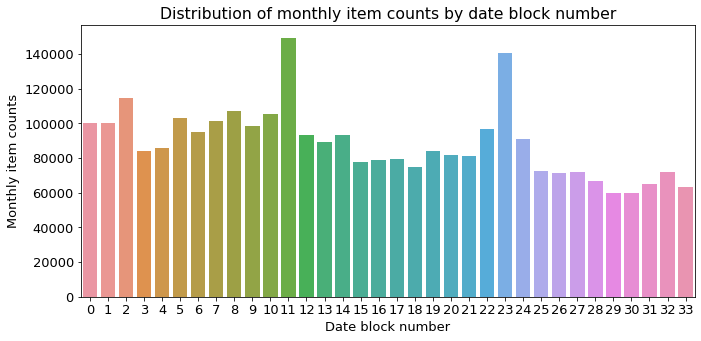

In [26]:
# plot item counts against each month (0-33 months)
# we can see how months 11 + 23 (December) show a spike in sales

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

mpl.rc('font', size=13)
figure, ax = plt.subplots() 
figure.set_size_inches(11, 5)

# total montly item sales
# group by date, provide sum of item count
group_month_sum = merged.groupby('date_block_num').agg({'item_cnt_month': 'sum'})
group_month_sum = group_month_sum.reset_index()

sns.barplot(x='date_block_num', y='item_cnt_month', data=group_month_sum)
ax.set(title='Distribution of monthly item counts by date block number',
       xlabel='Date block number', 
       ylabel='Monthly item counts');

In [27]:
# append to test data set & set data types
test['date_block_num'] = 34
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)
# concatenate current dataset and test dataset
merged = pd.concat([merged, test], ignore_index=True, sort=False, keys=['date_block_num','shop_id','item_id'])
merged.fillna(0, inplace=True)


In [28]:
mx = merged.loc[merged['date_block_num'] == 34]
print(len(mx))
mx.head()
print(len(test))


214200
214200


In [29]:
# now, include the items dataset and merge on item id
merged2 = merged.merge(items, on=['item_id'], how='left')
# we also now add shop name for city feature
merged2 = merged2.merge(shops, on='shop_id')
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран"
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран"
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран"


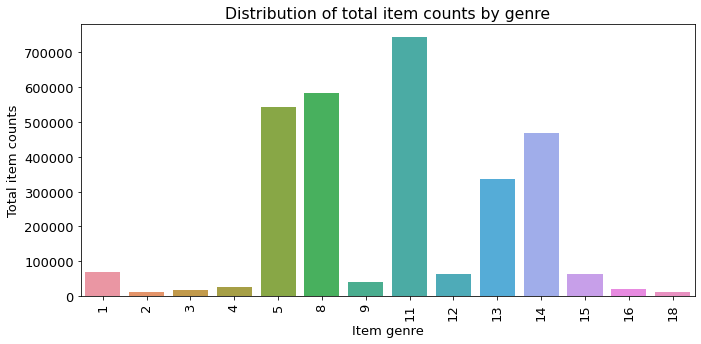

In [30]:
# here, we plot the distribution of total item counts by genre

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by item_category_id
group_cat_sum = merged2.groupby('genre_id').agg({'item_cnt_month': 'sum'})
group_cat_sum = group_cat_sum.reset_index()

# Extract only item categories with total sales > 10,000
group_cat_sum = group_cat_sum[group_cat_sum['item_cnt_month'] > 10000]

sns.barplot(x='genre_id', y='item_cnt_month', data=group_cat_sum)
ax.set(title='Distribution of total item counts by genre',
       xlabel='Item genre', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90) # Rotate X label

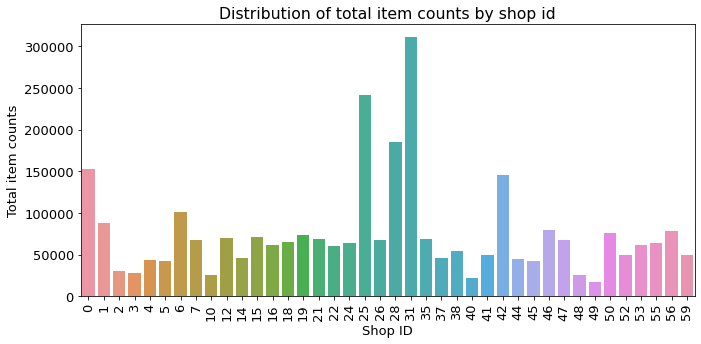

In [31]:
# plot distribution of total item counts by shop ID

figure, ax= plt.subplots() 
figure.set_size_inches(11, 5)

# Total item sales by shop_id
group_shop_sum = merged2.groupby('shop_id').agg({'item_cnt_month': 'sum'})
group_shop_sum = group_shop_sum.reset_index()

group_shop_sum = group_shop_sum[group_shop_sum['item_cnt_month'] > 10000]

sns.barplot(x='shop_id', y='item_cnt_month', data=group_shop_sum)
ax.set(title='Distribution of total item counts by shop id',
       xlabel='Shop ID', 
       ylabel='Total item counts')
ax.tick_params(axis='x', labelrotation=90)

In [32]:
# normalize month into 1-12 format instead of 0-33
merged2["month_id"] = merged2['date_block_num'].apply(lambda dbn: 1 + dbn % 12)
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1


In [33]:
# select may, for example, and let's now inspect for trends during the days of the month
month_inspection = sales_train.loc[sales_train["date_block_num"] == 5]
month_inspection = month_inspection.groupby(['date']).agg({'item_cnt_day': ['sum']})
month_inspection = month_inspection.reset_index()

month_inspection["date"] = month_inspection['date'].apply(lambda x: int(x.split('.')[0]) )
month_inspection.head(5)

,date,item_cnt_day
,,sum
0,1,4823.0
1,2,3663.0
2,3,2733.0
3,4,2753.0
4,5,2892.0


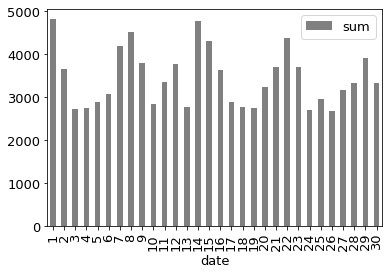

In [34]:
# here, we are able to see that weekends correlate with more sales.
month_inspection.plot.bar(x="date", y="item_cnt_day", color='grey');

In [35]:
# given a month, compute the number of weekends so that we can use as an additional feature
def count_days(date_block_num):
    year = 2013 + date_block_num // 12
    month = 1 + date_block_num % 12
    weeknd_count = len([1 for i in calendar.monthcalendar(year, month) if i[6] != 0])
    return weeknd_count
map_dict = {i: count_days(i) for i in range(35)}

merged2['weeknd_count'] = merged2['date_block_num'].apply(lambda x: map_dict[x])
merged2.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id,weeknd_count
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1,4
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1,4


In [36]:
# lagging is a critical feature for our training process.
# it allows for model to look back in time and see how the shop performed in the months before.
# currently, we are looking up to 3 months back
def lag_feature(df, col):
    tmp = df[['date_block_num','shop_id','item_id',col]]
    for i in [1, 2, 3]:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
        df[col+'_lag_'+str(i)] = df[col+'_lag_'+str(i)].astype('float16')
    del tmp
    return df

In [37]:
merged2 = lag_feature(merged2, 'item_cnt_month')
merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']] = merged2[['item_cnt_month_lag_1', 'item_cnt_month_lag_2', 'item_cnt_month_lag_3']].fillna(value=0)

In [38]:
# let's take a look here and now we can see we have counts for the number of items sold
# 1 month before, 2 months before, and 3.
merged2.head(500000)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,shop_name,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3
0,0,0,32,6.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
1,0,0,33,3.0,347.0,0.0,37,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
2,0,0,35,1.0,247.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
3,0,0,43,1.0,221.0,0.0,40,11,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
4,0,0,51,2.0,128.5,0.0,57,13,"!Якутск Орджоникидзе, 56 фран",1,4,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,34,19,10954,0.0,0.0,99303.0,37,11,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0
499996,34,19,10945,0.0,0.0,99304.0,57,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0
499997,34,19,10942,0.0,0.0,99305.0,55,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,1.0
499998,34,19,10940,0.0,0.0,99306.0,58,13,"Курск ТЦ ""Пушкинский""",11,5,0.0,0.0,0.0


In [39]:
# create feature city based on location of shop
merged2['city'] = merged2['shop_name'].apply(lambda x: x.split()[0].lower())
merged2.loc[merged2.city == '!якутск', 'city'] = 'якутск' # correct for error
merged2['city_code'] = LabelEncoder().fit_transform(merged2['city'])
merged2 = merged2.drop(columns=['city', 'shop_name'])
merged2.head()
# merged2 = merged2.drop(columns=['shop_name'])

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code
0,0,0,32,6.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,26
1,0,0,33,3.0,347.0,0.0,37,11,1,4,0.0,0.0,0.0,26
2,0,0,35,1.0,247.0,0.0,40,11,1,4,0.0,0.0,0.0,26
3,0,0,43,1.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,26
4,0,0,51,2.0,128.5,0.0,57,13,1,4,0.0,0.0,0.0,26


In [40]:
# create item first interaction feature - determines if this is the first time the product is being
# purchased at the shop
first_item_block = merged2.groupby(['item_id'])['date_block_num'].min().reset_index()
first_item_block['item_first_interaction'] = 1

first_shop_item_buy_block = merged2[merged2['date_block_num'] > 0].groupby(['shop_id', 'item_id'])['date_block_num'].min().reset_index()
first_shop_item_buy_block['first_date_block_num'] = first_shop_item_buy_block['date_block_num']

merged2 = pd.merge(merged2, first_item_block[['item_id', 'date_block_num', 'item_first_interaction']], on=['item_id', 'date_block_num'], how='left')
merged2 = pd.merge(merged2, first_shop_item_buy_block[['item_id', 'shop_id', 'first_date_block_num']], on=['item_id', 'shop_id'], how='left')

merged2['first_date_block_num'].fillna(100, inplace=True)
merged2['shop_item_sold_before'] = (merged2['first_date_block_num'] < merged2['date_block_num']).astype('int8')
merged2.drop(['first_date_block_num'], axis=1, inplace=True)

merged2['item_first_interaction'].fillna(0, inplace=True)
merged2['shop_item_sold_before'].fillna(0, inplace=True)
 
merged2['item_first_interaction'] = merged2['item_first_interaction'].astype('int8')  
merged2['shop_item_sold_before'] = merged2['shop_item_sold_before'].astype('int8')
merged2.head(1000000)

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code,item_first_interaction,shop_item_sold_before
0,0,0,32,6.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,26,1,0
1,0,0,33,3.0,347.0,0.0,37,11,1,4,0.0,0.0,0.0,26,1,0
2,0,0,35,1.0,247.0,0.0,40,11,1,4,0.0,0.0,0.0,26,1,0
3,0,0,43,1.0,221.0,0.0,40,11,1,4,0.0,0.0,0.0,26,1,0
4,0,0,51,2.0,128.5,0.0,57,13,1,4,0.0,0.0,0.0,26,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,20,38,9805,1.0,199.0,0.0,40,11,9,4,0.0,1.0,0.0,15,0,1
999996,20,38,9845,1.0,149.0,0.0,40,11,9,4,2.0,0.0,1.0,15,0,1
999997,20,38,9986,1.0,199.0,0.0,37,11,9,4,0.0,0.0,0.0,15,0,1
999998,20,38,10006,1.0,279.3,0.0,41,11,9,4,0.0,1.0,0.0,15,0,1


In [41]:

y = merged2.loc[ (merged2['date_block_num'] == 0) & (merged2['shop_id'] == 13) & (merged2['item_id'] == 32)]
y.head()

,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code,item_first_interaction,shop_item_sold_before


In [42]:
##Add target encoding for item/shop for last 3 months 
##item_id_target_mean = merged2.groupby(['date_block_num','item_id', 'shop_id'])['item_cnt_month'].mean().reset_index().rename(columns={
    ##"item_cnt_month": "item_shop_target_enc"}, errors="raise")

##merged2 = pd.merge(merged2, item_id_target_mean, on=['date_block_num','item_id', 'shop_id'], how='left')

##merged2.head()

In [43]:
#xm = merged2.loc[merged2['item_cnt_month'] != merged2['item_shop_target_enc']]
#xm.head()


In [44]:
df2 = merged2.loc[merged2['date_block_num'] == 34]
df2.head()


,date_block_num,shop_id,item_id,item_cnt_month,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code,item_first_interaction,shop_item_sold_before
64793,34,0,5037,0.0,0.0,137700.0,19,5,11,5,1.0,0.0,1.0,26,0,1
64794,34,0,5320,0.0,0.0,137701.0,55,13,11,5,0.0,0.0,0.0,26,1,0
64795,34,0,5233,0.0,0.0,137702.0,19,5,11,5,1.0,4.0,1.0,26,0,1
64796,34,0,5232,0.0,0.0,137703.0,23,5,11,5,1.0,1.0,3.0,26,0,1
64797,34,0,5268,0.0,0.0,137704.0,20,5,11,5,0.0,0.0,0.0,26,1,0


In [45]:
# create final dataset
# split data into training validation and testing
# we originally put them all together to make feature engineering easier
df = merged2
X_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)].drop(['item_cnt_month'], axis=1)
Y_train = df[(df.date_block_num >= 3) & (df.date_block_num < 33)]['item_cnt_month']

X_valid = df[df.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = df[df.date_block_num == 33]['item_cnt_month']

X_test = df[df.date_block_num == 34].drop(['item_cnt_month'], axis=1)

In [46]:
X_train.head(10)

,date_block_num,shop_id,item_id,mean_price,ID,item_category_id,genre_id,month_id,weeknd_count,item_cnt_month_lag_1,item_cnt_month_lag_2,item_cnt_month_lag_3,city_code,item_first_interaction,shop_item_sold_before
7474,3,0,30,399.0,0.0,40,11,4,4,24.0,31.0,0.0,26,0,1
7475,3,0,31,699.0,0.0,37,11,4,4,10.0,11.0,0.0,26,0,1
7476,3,0,32,349.0,0.0,40,11,4,4,12.0,10.0,6.0,26,0,1
7477,3,0,34,149.0,0.0,40,11,4,4,0.0,0.0,0.0,26,0,0
7478,3,0,37,149.0,0.0,40,11,4,4,0.0,0.0,0.0,26,0,0
7479,3,0,44,249.0,0.0,57,13,4,4,0.0,0.0,0.0,26,0,0
7480,3,0,46,249.0,0.0,57,13,4,4,0.0,0.0,0.0,26,0,0
7481,3,0,82,299.0,0.0,37,11,4,4,0.0,0.0,0.0,26,1,0
7482,3,0,111,199.0,0.0,57,13,4,4,1.0,1.0,1.0,26,0,1
7483,3,0,113,199.0,0.0,57,13,4,4,0.0,0.0,0.0,26,0,0


In [ ]:
# begin training using lgb
feature_name = X_train.columns.tolist()

params = {
    'objective': 'mse',
    'metric': 'rmse',
    'num_leaves': 2 ** 7 - 1,
    'learning_rate': 0.005,
    'feature_fraction': 0.75,
    'bagging_fraction': 0.75,
    'bagging_freq': 5,
    'seed': 1,
    'verbose': 1
}

feature_name_indexes = [ 
                        'item_category_id',
                        'genre_id',
                        'city_code',
]

lgb_train = lgb.Dataset(X_train[feature_name], Y_train)
lgb_eval = lgb.Dataset(X_valid[feature_name], Y_valid, reference=lgb_train)

evals_result = {}
gbm = lgb.train(
        params, 
        lgb_train, # data to be trained on
        num_boost_round=10000, # boosting iterations
        valid_sets=(lgb_train, lgb_eval), # data to be evaluted on
        feature_name = feature_name, # define numerical features
        categorical_feature = feature_name_indexes, # define categorical features
        verbose_eval=5, #print eval metric on every boosting iteration
        evals_result = evals_result, # where to store eval results
        ##early_stopping_rounds = 500
)

/home/aj/.local/lib/python3.8/site-packages/lightgbm/basic.py:1705: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['city_code', 'genre_id', 'item_category_id']
  _log_warning('categorical_feature in Dataset is overridden.\n'


[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005000 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1109
[LightGBM] [Info] Number of data points in the train set: 1158064, number of used features: 14
[LightGBM] [Info] Start training from score 2.273285
[5]	training's rmse: 8.77918	valid_1's rmse: 6.67637
[10]	training's rmse: 8.65494	valid_1's rmse: 6.55949
[15]	training's rmse: 8.53572	valid_1's rmse: 6.46017
[20]	training's rmse: 8.4165	valid_1's rmse: 6.34867
[25]	training's rmse: 8.30143	valid_1's rmse: 6.24177
[30]	training's rmse: 8.19282	valid_1's rmse: 6.14701
[35]	training's rmse: 8.08201	valid_1's rmse: 6.04879
[40]	training's rmse: 7.97695	valid_1's rmse: 5.93891
[45]	training's rmse: 7.87841	valid_1's rmse: 5.84275
[50]	training's rmse: 7.78302	valid_1's rmse: 5.77271
[55]	training's rmse: 7.68903	valid_1's rmse: 5.688

[725]	training's rmse: 4.4565	valid_1's rmse: 4.5596
[730]	training's rmse: 4.45164	valid_1's rmse: 4.55849
[735]	training's rmse: 4.44695	valid_1's rmse: 4.55705
[740]	training's rmse: 4.44267	valid_1's rmse: 4.55242
[745]	training's rmse: 4.43781	valid_1's rmse: 4.54864
[750]	training's rmse: 4.43176	valid_1's rmse: 4.5443
[755]	training's rmse: 4.42709	valid_1's rmse: 4.53563
[760]	training's rmse: 4.4201	valid_1's rmse: 4.54546
[765]	training's rmse: 4.41654	valid_1's rmse: 4.54291
[770]	training's rmse: 4.41002	valid_1's rmse: 4.55031
[775]	training's rmse: 4.40379	valid_1's rmse: 4.55359
[780]	training's rmse: 4.39899	valid_1's rmse: 4.5535
[785]	training's rmse: 4.39439	valid_1's rmse: 4.55715
[790]	training's rmse: 4.38714	valid_1's rmse: 4.55991
[795]	training's rmse: 4.38228	valid_1's rmse: 4.55615
[800]	training's rmse: 4.37741	valid_1's rmse: 4.56114
[805]	training's rmse: 4.37323	valid_1's rmse: 4.55807
[810]	training's rmse: 4.36926	valid_1's rmse: 4.55709
[815]	training'

[1465]	training's rmse: 3.96634	valid_1's rmse: 4.48799
[1470]	training's rmse: 3.96421	valid_1's rmse: 4.48809
[1475]	training's rmse: 3.96253	valid_1's rmse: 4.48687
[1480]	training's rmse: 3.96095	valid_1's rmse: 4.48349
[1485]	training's rmse: 3.95869	valid_1's rmse: 4.4797
[1490]	training's rmse: 3.95654	valid_1's rmse: 4.48194
[1495]	training's rmse: 3.95449	valid_1's rmse: 4.48011
[1500]	training's rmse: 3.95298	valid_1's rmse: 4.4794
[1505]	training's rmse: 3.94977	valid_1's rmse: 4.49467
[1510]	training's rmse: 3.94784	valid_1's rmse: 4.49262
[1515]	training's rmse: 3.94587	valid_1's rmse: 4.49111
[1520]	training's rmse: 3.94256	valid_1's rmse: 4.4963
[1525]	training's rmse: 3.94063	valid_1's rmse: 4.49774
[1530]	training's rmse: 3.93927	valid_1's rmse: 4.49423
[1535]	training's rmse: 3.93665	valid_1's rmse: 4.49107
[1540]	training's rmse: 3.93449	valid_1's rmse: 4.48847
[1545]	training's rmse: 3.93301	valid_1's rmse: 4.4879
[1550]	training's rmse: 3.93106	valid_1's rmse: 4.48

[2205]	training's rmse: 3.68417	valid_1's rmse: 4.49465
[2210]	training's rmse: 3.68276	valid_1's rmse: 4.50141
[2215]	training's rmse: 3.68108	valid_1's rmse: 4.49885
[2220]	training's rmse: 3.67981	valid_1's rmse: 4.50387
[2225]	training's rmse: 3.67836	valid_1's rmse: 4.50476
[2230]	training's rmse: 3.67698	valid_1's rmse: 4.50075
[2235]	training's rmse: 3.67544	valid_1's rmse: 4.49532
[2240]	training's rmse: 3.67365	valid_1's rmse: 4.49694
[2245]	training's rmse: 3.67248	valid_1's rmse: 4.49679
[2250]	training's rmse: 3.67103	valid_1's rmse: 4.49575
[2255]	training's rmse: 3.66997	valid_1's rmse: 4.49302
[2260]	training's rmse: 3.66826	valid_1's rmse: 4.4916
[2265]	training's rmse: 3.66584	valid_1's rmse: 4.49499
[2270]	training's rmse: 3.66451	valid_1's rmse: 4.49261
[2275]	training's rmse: 3.66348	valid_1's rmse: 4.49031
[2280]	training's rmse: 3.66139	valid_1's rmse: 4.48932
[2285]	training's rmse: 3.65993	valid_1's rmse: 4.48813
[2290]	training's rmse: 3.65779	valid_1's rmse: 4

[2955]	training's rmse: 3.48021	valid_1's rmse: 4.52901
[2960]	training's rmse: 3.47925	valid_1's rmse: 4.52759
[2965]	training's rmse: 3.47714	valid_1's rmse: 4.53231
[2970]	training's rmse: 3.47566	valid_1's rmse: 4.53277
[2975]	training's rmse: 3.47426	valid_1's rmse: 4.52981
[2980]	training's rmse: 3.47334	valid_1's rmse: 4.52848
[2985]	training's rmse: 3.47224	valid_1's rmse: 4.52858
[2990]	training's rmse: 3.47057	valid_1's rmse: 4.53021
[2995]	training's rmse: 3.46934	valid_1's rmse: 4.52869
[3000]	training's rmse: 3.46797	valid_1's rmse: 4.52869
[3005]	training's rmse: 3.46614	valid_1's rmse: 4.52707
[3010]	training's rmse: 3.46534	valid_1's rmse: 4.52718
[3015]	training's rmse: 3.46394	valid_1's rmse: 4.52887
[3020]	training's rmse: 3.46313	valid_1's rmse: 4.52726
[3025]	training's rmse: 3.46233	valid_1's rmse: 4.52508
[3030]	training's rmse: 3.4612	valid_1's rmse: 4.52727
[3035]	training's rmse: 3.46027	valid_1's rmse: 4.52592
[3040]	training's rmse: 3.45911	valid_1's rmse: 4

[3695]	training's rmse: 3.31332	valid_1's rmse: 4.57296
[3700]	training's rmse: 3.3121	valid_1's rmse: 4.57352
[3705]	training's rmse: 3.31101	valid_1's rmse: 4.5754
[3710]	training's rmse: 3.31014	valid_1's rmse: 4.57464
[3715]	training's rmse: 3.30968	valid_1's rmse: 4.5716
[3720]	training's rmse: 3.30835	valid_1's rmse: 4.57119
[3725]	training's rmse: 3.30765	valid_1's rmse: 4.57242
[3730]	training's rmse: 3.30628	valid_1's rmse: 4.57222
[3735]	training's rmse: 3.30531	valid_1's rmse: 4.57093
[3740]	training's rmse: 3.30463	valid_1's rmse: 4.56971
[3745]	training's rmse: 3.30358	valid_1's rmse: 4.57074
[3750]	training's rmse: 3.30206	valid_1's rmse: 4.57012
[3755]	training's rmse: 3.30092	valid_1's rmse: 4.57072
[3760]	training's rmse: 3.29964	valid_1's rmse: 4.57038
[3765]	training's rmse: 3.29791	valid_1's rmse: 4.57372
[3770]	training's rmse: 3.29682	valid_1's rmse: 4.57526
[3775]	training's rmse: 3.2959	valid_1's rmse: 4.57508
[3780]	training's rmse: 3.2949	valid_1's rmse: 4.572

[4435]	training's rmse: 3.17555	valid_1's rmse: 4.58345
[4440]	training's rmse: 3.17496	valid_1's rmse: 4.58248
[4445]	training's rmse: 3.17434	valid_1's rmse: 4.58133
[4450]	training's rmse: 3.17349	valid_1's rmse: 4.58244
[4455]	training's rmse: 3.17237	valid_1's rmse: 4.58058
[4460]	training's rmse: 3.17171	valid_1's rmse: 4.57974
[4465]	training's rmse: 3.17082	valid_1's rmse: 4.57853
[4470]	training's rmse: 3.16961	valid_1's rmse: 4.57931
[4475]	training's rmse: 3.16906	valid_1's rmse: 4.5795
[4480]	training's rmse: 3.16792	valid_1's rmse: 4.57831
[4485]	training's rmse: 3.16688	valid_1's rmse: 4.57864
[4490]	training's rmse: 3.16601	valid_1's rmse: 4.57662
[4495]	training's rmse: 3.16541	valid_1's rmse: 4.57748
[4500]	training's rmse: 3.16442	valid_1's rmse: 4.57668
[4505]	training's rmse: 3.16267	valid_1's rmse: 4.57899
[4510]	training's rmse: 3.16176	valid_1's rmse: 4.58328
[4515]	training's rmse: 3.16109	valid_1's rmse: 4.58165
[4520]	training's rmse: 3.16052	valid_1's rmse: 4

[5185]	training's rmse: 3.06401	valid_1's rmse: 4.58878
[5190]	training's rmse: 3.06326	valid_1's rmse: 4.58888
[5195]	training's rmse: 3.06275	valid_1's rmse: 4.58958
[5200]	training's rmse: 3.06202	valid_1's rmse: 4.59024
[5205]	training's rmse: 3.06112	valid_1's rmse: 4.59035
[5210]	training's rmse: 3.06045	valid_1's rmse: 4.591
[5215]	training's rmse: 3.0597	valid_1's rmse: 4.59098
[5220]	training's rmse: 3.05914	valid_1's rmse: 4.59182
[5225]	training's rmse: 3.05832	valid_1's rmse: 4.59112
[5230]	training's rmse: 3.05781	valid_1's rmse: 4.5904
[5235]	training's rmse: 3.05682	valid_1's rmse: 4.58967
[5240]	training's rmse: 3.05641	valid_1's rmse: 4.59044
[5245]	training's rmse: 3.05561	valid_1's rmse: 4.59004
[5250]	training's rmse: 3.05473	valid_1's rmse: 4.59083
[5255]	training's rmse: 3.05392	valid_1's rmse: 4.5916
[5260]	training's rmse: 3.05301	valid_1's rmse: 4.59159
[5265]	training's rmse: 3.05241	valid_1's rmse: 4.58876
[5270]	training's rmse: 3.05171	valid_1's rmse: 4.588

[5930]	training's rmse: 2.96012	valid_1's rmse: 4.61735
[5935]	training's rmse: 2.95918	valid_1's rmse: 4.61634
[5940]	training's rmse: 2.95858	valid_1's rmse: 4.61983
[5945]	training's rmse: 2.95808	valid_1's rmse: 4.62028
[5950]	training's rmse: 2.95731	valid_1's rmse: 4.61907
[5955]	training's rmse: 2.9567	valid_1's rmse: 4.61965
[5960]	training's rmse: 2.95616	valid_1's rmse: 4.61761
[5965]	training's rmse: 2.95562	valid_1's rmse: 4.61678
[5970]	training's rmse: 2.95494	valid_1's rmse: 4.61658
[5975]	training's rmse: 2.95426	valid_1's rmse: 4.61631
[5980]	training's rmse: 2.95362	valid_1's rmse: 4.61559
[5985]	training's rmse: 2.95294	valid_1's rmse: 4.61592
[5990]	training's rmse: 2.95236	valid_1's rmse: 4.61756
[5995]	training's rmse: 2.95169	valid_1's rmse: 4.61994
[6000]	training's rmse: 2.95107	valid_1's rmse: 4.61865
[6005]	training's rmse: 2.95035	valid_1's rmse: 4.61836
[6010]	training's rmse: 2.94975	valid_1's rmse: 4.61777
[6015]	training's rmse: 2.94922	valid_1's rmse: 4

[6670]	training's rmse: 2.87365	valid_1's rmse: 4.63968
[6675]	training's rmse: 2.87296	valid_1's rmse: 4.64107
[6680]	training's rmse: 2.87248	valid_1's rmse: 4.64028
[6685]	training's rmse: 2.87174	valid_1's rmse: 4.64118
[6690]	training's rmse: 2.87134	valid_1's rmse: 4.64166
[6695]	training's rmse: 2.87092	valid_1's rmse: 4.64096
[6700]	training's rmse: 2.87043	valid_1's rmse: 4.64066
[6705]	training's rmse: 2.86949	valid_1's rmse: 4.64303
[6710]	training's rmse: 2.86881	valid_1's rmse: 4.64344
[6715]	training's rmse: 2.86843	valid_1's rmse: 4.64176
[6720]	training's rmse: 2.86807	valid_1's rmse: 4.64226
[6725]	training's rmse: 2.86776	valid_1's rmse: 4.64291
[6730]	training's rmse: 2.8673	valid_1's rmse: 4.64332
[6735]	training's rmse: 2.86664	valid_1's rmse: 4.64288
[6740]	training's rmse: 2.8658	valid_1's rmse: 4.64249
[6745]	training's rmse: 2.86541	valid_1's rmse: 4.64201
[6750]	training's rmse: 2.86491	valid_1's rmse: 4.64262
[6755]	training's rmse: 2.86427	valid_1's rmse: 4.

[7415]	training's rmse: 2.79901	valid_1's rmse: 4.65444
[7420]	training's rmse: 2.79874	valid_1's rmse: 4.65253
[7425]	training's rmse: 2.7983	valid_1's rmse: 4.65345
[7430]	training's rmse: 2.798	valid_1's rmse: 4.65332
[7435]	training's rmse: 2.79746	valid_1's rmse: 4.65482
[7440]	training's rmse: 2.79689	valid_1's rmse: 4.65493
[7445]	training's rmse: 2.79625	valid_1's rmse: 4.655
[7450]	training's rmse: 2.79587	valid_1's rmse: 4.65573
[7455]	training's rmse: 2.79558	valid_1's rmse: 4.65583
[7460]	training's rmse: 2.79494	valid_1's rmse: 4.65562
[7465]	training's rmse: 2.79467	valid_1's rmse: 4.65502
[7470]	training's rmse: 2.7943	valid_1's rmse: 4.65406
[7475]	training's rmse: 2.79401	valid_1's rmse: 4.65431
[7480]	training's rmse: 2.79373	valid_1's rmse: 4.65428
[7485]	training's rmse: 2.79325	valid_1's rmse: 4.65651
[7490]	training's rmse: 2.7927	valid_1's rmse: 4.6568
[7495]	training's rmse: 2.79236	valid_1's rmse: 4.6559
[7500]	training's rmse: 2.79184	valid_1's rmse: 4.65683
[

[8165]	training's rmse: 2.73192	valid_1's rmse: 4.67747
[8170]	training's rmse: 2.73125	valid_1's rmse: 4.67858
[8175]	training's rmse: 2.73086	valid_1's rmse: 4.67905
[8180]	training's rmse: 2.73032	valid_1's rmse: 4.67878
[8185]	training's rmse: 2.72991	valid_1's rmse: 4.67918
[8190]	training's rmse: 2.7296	valid_1's rmse: 4.67847
[8195]	training's rmse: 2.72917	valid_1's rmse: 4.67877
[8200]	training's rmse: 2.72882	valid_1's rmse: 4.67949
[8205]	training's rmse: 2.72841	valid_1's rmse: 4.67959
[8210]	training's rmse: 2.72789	valid_1's rmse: 4.68065
[8215]	training's rmse: 2.72716	valid_1's rmse: 4.68182
[8220]	training's rmse: 2.72683	valid_1's rmse: 4.68119
[8225]	training's rmse: 2.72639	valid_1's rmse: 4.68118
[8230]	training's rmse: 2.72589	valid_1's rmse: 4.68073
[8235]	training's rmse: 2.7254	valid_1's rmse: 4.6832
[8240]	training's rmse: 2.72498	valid_1's rmse: 4.68383
[8245]	training's rmse: 2.72464	valid_1's rmse: 4.68292
[8250]	training's rmse: 2.72413	valid_1's rmse: 4.6

[8905]	training's rmse: 2.67358	valid_1's rmse: 4.70383
[8910]	training's rmse: 2.67312	valid_1's rmse: 4.70416
[8915]	training's rmse: 2.67268	valid_1's rmse: 4.70439
[8920]	training's rmse: 2.67234	valid_1's rmse: 4.70437
[8925]	training's rmse: 2.67205	valid_1's rmse: 4.70367
[8930]	training's rmse: 2.67155	valid_1's rmse: 4.70461
[8935]	training's rmse: 2.67128	valid_1's rmse: 4.70383
[8940]	training's rmse: 2.67086	valid_1's rmse: 4.70462
[8945]	training's rmse: 2.67055	valid_1's rmse: 4.70504
[8950]	training's rmse: 2.67008	valid_1's rmse: 4.70496
[8955]	training's rmse: 2.66965	valid_1's rmse: 4.7043
[8960]	training's rmse: 2.66897	valid_1's rmse: 4.70467
[8965]	training's rmse: 2.66853	valid_1's rmse: 4.70457
[8970]	training's rmse: 2.66806	valid_1's rmse: 4.70429
[8975]	training's rmse: 2.66776	valid_1's rmse: 4.70398
[8980]	training's rmse: 2.66717	valid_1's rmse: 4.70418
[8985]	training's rmse: 2.66666	valid_1's rmse: 4.70792
[8990]	training's rmse: 2.66613	valid_1's rmse: 4

In [ ]:
# plot feature significance to training
lgb.plot_importance(
    gbm, 
    max_num_features=50, 
    importance_type='gain', 
    figsize=(12,8));

In [ ]:
# predict & export submissions
test = pd.read_csv('competitive-data-science-predict-future-sales/test.csv')
Y_test = gbm.predict(X_test[feature_name]).clip(0, 20)



submission = pd.DataFrame({ "ID": test.index, "item_cnt_month": Y_test }) 
submission.to_csv('gbm_submissionXYZZ.csv', index=False)

In [ ]:
print(len(Y_test))

In [ ]:
print(len(test))

In [ ]:
test.head()


In [ ]:
print(Y_test)


In [ ]:

print(len(X_test))